<a href="https://colab.research.google.com/github/mohansameer1983/AI-Finance/blob/main/Sentiment_Analysis_Ethereum_Price_Pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 63 kB 5.8 MB/s 
     |████████████████████████████████| 6.4 MB 8.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
from matplotlib.dates import DateFormatter
%matplotlib inline
import os
import re

import math
import yfinance as yf

import tweepy
import json

import pandas_datareader as web
from sklearn.preprocessing import LabelEncoder

#Setup Environment

In [3]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def getTwitterAuthJson():
  with open('/content/drive/MyDrive/Colab Notebooks/API/twitter_api_keystore.json', 'r') as file_to_read:
    json_data = json.load(file_to_read)
  return json_data

auth_json = getTwitterAuthJson()  

#Fetch Tweets

In [4]:
from datetime import datetime, timedelta
import requests

In [ ]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter 

# setup the API request
def twitter_search(query, start_date, end_date, max_results):
  search_url_v1 = "https://api.twitter.com/1.1/search/tweets.json"
  search_url_v2 = 'https://api.twitter.com/2/tweets/search/recent'

  #change params based on the endpoint you are using
  query_params_v1 = {'q': query,
                  'start_time': start_date,
                  'end_time': end_date,
                  'max_results': max_results,
                  'tweet_mode': 'extended',
                  'lang': 'en'}
  query_params_v2 = {
      'query': query,
      'max_results': '100',
      'tweet.fields': 'created_at,lang'
  }
                    
  headers = {'authorization': f'Bearer {auth_json["bearer_token"]}'}

  now = datetime.now()  # get the current datetime, this is our starting point
  last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
  now = now.strftime(dtformat)  # convert now datetime to format for API
  now=time_travel(now, 1)

  df = pd.DataFrame()

  while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 7 days ago, break the loop
        break
    pre60 = time_travel(now, 60)  # get 60 minutes before 'now'
    # assign from and to datetime parameters for the API
    query_params_v2['start_time'] = pre60
    query_params_v2['end_time'] = now

    response = requests.get(
      search_url_v2,
      params=query_params_v2,
      headers=headers)
    
    now = pre60  # move the window 60 minutes earlier
  
    # V1 Tweet Loop
    '''
    for tweet in response.json()['statuses']:
        row = get_data(tweet)
        df = df.append(row, ignore_index=True)
    '''
    # V2 Tweet Loop 
    print(response.json())
    for tweet in response.json()['data']:
      row = get_data(tweet)  # we defined this function earlier
      df = df.append(row, ignore_index=True)
  return df

def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text']
    }
    return data


# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)


# Uncomment below two lines when to fetch latest data from Twitter
#twitter_df = twitter_search('#Ethereum (Bitcoin OR Btc) lang:en','2022-04-08T20:58:51.000Z','2022-04-14T20:42:51.000Z',100)
#twitter_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Finance/twitter_etherium_data.csv')
twitter_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Finance/twitter_etherium_data.csv')

In [ ]:
twitter_df

,Unnamed: 0,id,created_at,text
0,0,1515085432794624008,2022-04-15T21:51:30.000Z,RT @YachtClub_NFT: 💎ETH #Giveaway💎\n\n🎁Prizes:...
1,1,1515085432677150723,2022-04-15T21:51:30.000Z,RT @YachtClub_NFT: 💎ETH #Giveaway💎\n\n🎁Prizes:...
2,2,1515085423760060426,2022-04-15T21:51:28.000Z,RT @DancingDeerNFT: 🎁NFT+ETH #GIVEAWAY🎁\n\nPri...
3,3,1515085423554572291,2022-04-15T21:51:28.000Z,RT @Ceyhunakan60: @AltcoinDailyio @AltcoinDail...
4,4,1515085420853399553,2022-04-15T21:51:27.000Z,I just caught 110k just for free.! #btc #bitco...
...,...,...,...,...
14317,14317,1512925740727246850,2022-04-09T22:49:40.000Z,RT @ApesGenX: The virus never stood a chance\n...
14318,14318,1512925739150102534,2022-04-09T22:49:39.000Z,RT @DarrenPromoter: 🐺 Star Wolvez Generative 🐺...
14319,14319,1512925721982865410,2022-04-09T22:49:35.000Z,"Floor price 0.1 eth \n\ndifferent collection, ..."
14320,14320,1512925714856951810,2022-04-09T22:49:33.000Z,RT @Bitsubishi: 🌍 Presenting #Bitsubishi - The...


###Alternative Fetch Tweets Method

In [ ]:
# Another way to fetch data using Tweepy
def login():
    auth = tweepy.OAuthHandler(auth_json["consumer_key"], auth_json["consumer_secret"])
    auth.set_access_token(auth_json["access_token"], auth_json["access_token_secret"])
    api = tweepy.API(auth, wait_on_rate_limit=True)    
    return api

def login1():
    access_token = getTwitterAuthJson()
    client = tweepy.Client(bearer_token=access_token)
    print("client:", client)    
    return client

twitter_api = login()

In [ ]:
# Search Twitter
def twitter_search(api, query, max_results, columns, **kw):
    try:
      date_since = "2022-04-01"
      tweets = api.search_tweets(q=query, count=max_results, 
                                 lang="en", 
                                 tweet_mode="extended", 
                                 result_type="mixed",                     
                                 **kw)      
    except BaseException as e:
       print('failed on_status,',str(e))
        
    tweets_list = []
    for tweet in tweets:
        tweets_list.append((tweet.id, tweet.created_at,tweet.user.screen_name,tweet.full_text))
        
    df = pd.DataFrame(list(tweets_list), columns=columns)
    return df

#Tweets Preprocessing

In [ ]:
def clean_data(df):
  for ind in df.index:
    
    string = df["text"][ind]
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    df["text"][ind]=string
  return df


In [ ]:
twitter_cleaned_df = twitter_df.copy()

# use regex expressions (in clean function) to clean tweets
twitter_cleaned_df = clean_data(twitter_cleaned_df)
twitter_cleaned_df.head(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,id,created_at,text
0,0,1515085432794624008,2022-04-15T21:51:30.000Z,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...
1,1,1515085432677150723,2022-04-15T21:51:30.000Z,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...
2,2,1515085423760060426,2022-04-15T21:51:28.000Z,RT DancingDeerNFT 🎁NFT+ETH GIVEAWAY🎁 Prizes 🏆2...
3,3,1515085423554572291,2022-04-15T21:51:28.000Z,RT Ceyhunakan60 AltcoinDailyio AltcoinDailyio ...
4,4,1515085420853399553,2022-04-15T21:51:27.000Z,I just caught 110k just for free btc bitcoin b...
...,...,...,...,...
95,95,1515085154582208512,2022-04-15T21:50:24.000Z,BITCOIN getting ready to take off to moon altc...
96,96,1515085152120193031,2022-04-15T21:50:23.000Z,RT Nektapav kkoncrypto Shibnobi SHIBNOBI SHINJ...
97,97,1515085146755670023,2022-04-15T21:50:22.000Z,RT YachtClubNFT 💎ETH Giveaway💎 I found next Az...
98,98,1515085145832837126,2022-04-15T21:50:22.000Z,kenjori3 Whiteirons112 Foundation▲●■ 11 011 ET...


##Flair - Sentiment Analysis

In [ ]:
!pip install flair

     |████████████████████████████████| 401 kB 4.1 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 4.0 MB 31.3 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 981 kB 37.5 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 788 kB 50.5 MB/s 
     |████████████████████████████████| 1.6 MB 40.3 MB/s 
     |████████████████████████████████| 199 kB 49.5 MB/s 
     |████████████████████████████████| 6.6 MB 33.6 MB/s 
     |████████████████████████████████| 895 kB 50.1 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
  Created whe

In [ ]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-04-15 23:47:33,012 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp6w2krqcf


100%|██████████| 265512723/265512723 [00:29<00:00, 9090739.85B/s] 

2022-04-15 23:48:03,105 copying /tmp/tmp6w2krqcf to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-04-15 23:48:03,605 removing temp file /tmp/tmp6w2krqcf
2022-04-15 23:48:03,642 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
#Predicting using Flair

flair_predictions = []
flair_sentiments = []
def text_sentiment_flair(text):

  sentence = flair.data.Sentence(text)
  sentiment_model.predict(sentence)

  # extract sentiment prediction
  flair_predictions.append(sentence.labels[0].score)  # numerical score 0-1
  flair_sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
  return

twitter_cleaned_df.text.map(lambda x : text_sentiment_flair(x))
# add probability and sentiment predictions to tweets dataframe
twitter_cleaned_df['flair_probability'] = flair_predictions
twitter_cleaned_df['flair_sentiment'] = flair_sentiments

In [ ]:
twitter_cleaned_df

,Unnamed: 0,id,created_at,text,flair_probability,flair_sentiment
0,0,1515085432794624008,2022-04-15T21:51:30.000Z,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE
1,1,1515085432677150723,2022-04-15T21:51:30.000Z,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE
2,2,1515085423760060426,2022-04-15T21:51:28.000Z,RT DancingDeerNFT 🎁NFT+ETH GIVEAWAY🎁 Prizes 🏆2...,0.974201,POSITIVE
3,3,1515085423554572291,2022-04-15T21:51:28.000Z,RT Ceyhunakan60 AltcoinDailyio AltcoinDailyio ...,0.941798,NEGATIVE
4,4,1515085420853399553,2022-04-15T21:51:27.000Z,I just caught 110k just for free btc bitcoin b...,0.998054,NEGATIVE
...,...,...,...,...,...,...
14317,14317,1512925740727246850,2022-04-09T22:49:40.000Z,RT ApesGenX The virus never stood chance The t...,0.999942,NEGATIVE
14318,14318,1512925739150102534,2022-04-09T22:49:39.000Z,RT DarrenPromoter 🐺 Star Wolvez Generative 🐺 8...,0.997141,POSITIVE
14319,14319,1512925721982865410,2022-04-09T22:49:35.000Z,Floor price 01 eth different collection differ...,0.865415,NEGATIVE
14320,14320,1512925714856951810,2022-04-09T22:49:33.000Z,RT Bitsubishi 🌍 Presenting Bitsubishi The Most...,0.998281,POSITIVE


In [ ]:
#Save Predictions to file
twitter_cleaned_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Finance/twitter_etherium_flair_data.csv')

In [5]:
# Read already saved file
twitter_predicted_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Finance/twitter_etherium_flair_data.csv')
twitter_predicted_df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
twitter_predicted_df

,id,created_at,text,flair_probability,flair_sentiment
0,1515085432794624008,2022-04-15T21:51:30.000Z,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE
1,1515085432677150723,2022-04-15T21:51:30.000Z,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE
2,1515085423760060426,2022-04-15T21:51:28.000Z,RT DancingDeerNFT 🎁NFT+ETH GIVEAWAY🎁 Prizes 🏆2...,0.974201,POSITIVE
3,1515085423554572291,2022-04-15T21:51:28.000Z,RT Ceyhunakan60 AltcoinDailyio AltcoinDailyio ...,0.941798,NEGATIVE
4,1515085420853399553,2022-04-15T21:51:27.000Z,I just caught 110k just for free btc bitcoin b...,0.998054,NEGATIVE
...,...,...,...,...,...
14317,1512925740727246850,2022-04-09T22:49:40.000Z,RT ApesGenX The virus never stood chance The t...,0.999942,NEGATIVE
14318,1512925739150102534,2022-04-09T22:49:39.000Z,RT DarrenPromoter 🐺 Star Wolvez Generative 🐺 8...,0.997141,POSITIVE
14319,1512925721982865410,2022-04-09T22:49:35.000Z,Floor price 01 eth different collection differ...,0.865415,NEGATIVE
14320,1512925714856951810,2022-04-09T22:49:33.000Z,RT Bitsubishi 🌍 Presenting Bitsubishi The Most...,0.998281,POSITIVE


## Data Visualization

In [6]:
# Convert sentiments to numerical column and creation date to datetime type
twitter_predicted_vis_df = twitter_predicted_df.copy()
twitter_predicted_vis_df["flair_sentiment_code"] = np.where(twitter_predicted_vis_df["flair_sentiment"].str.contains("POSITIVE"), 1, -1)
twitter_predicted_vis_df['created_at'] = pd.to_datetime(twitter_predicted_df['created_at'])
twitter_predicted_vis_df = twitter_predicted_vis_df.drop(['id'], axis=1)
twitter_predicted_vis_df

,created_at,text,flair_probability,flair_sentiment,flair_sentiment_code
0,2022-04-15 21:51:30+00:00,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE,1
1,2022-04-15 21:51:30+00:00,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE,1
2,2022-04-15 21:51:28+00:00,RT DancingDeerNFT 🎁NFT+ETH GIVEAWAY🎁 Prizes 🏆2...,0.974201,POSITIVE,1
3,2022-04-15 21:51:28+00:00,RT Ceyhunakan60 AltcoinDailyio AltcoinDailyio ...,0.941798,NEGATIVE,-1
4,2022-04-15 21:51:27+00:00,I just caught 110k just for free btc bitcoin b...,0.998054,NEGATIVE,-1
...,...,...,...,...,...
14317,2022-04-09 22:49:40+00:00,RT ApesGenX The virus never stood chance The t...,0.999942,NEGATIVE,-1
14318,2022-04-09 22:49:39+00:00,RT DarrenPromoter 🐺 Star Wolvez Generative 🐺 8...,0.997141,POSITIVE,1
14319,2022-04-09 22:49:35+00:00,Floor price 01 eth different collection differ...,0.865415,NEGATIVE,-1
14320,2022-04-09 22:49:33+00:00,RT Bitsubishi 🌍 Presenting Bitsubishi The Most...,0.998281,POSITIVE,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


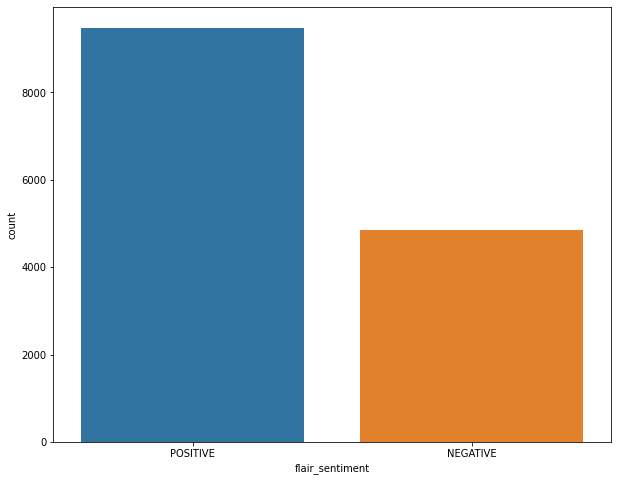

In [7]:
# plot sentiment distribution
plt.figure(figsize = (10,8))
sns.countplot(twitter_predicted_df['flair_sentiment'])
plt.show()

In [8]:
#Daily Tweets Processing
twitter_predicted_vis_df['created_on_date'] = [d.date() for d in twitter_predicted_vis_df['created_at']]
eda_df=twitter_predicted_vis_df.drop(columns=['created_at','text','flair_probability','flair_sentiment_code'])
eda_df.set_index('created_on_date',inplace=True)
eda_df

,flair_sentiment
created_on_date,
2022-04-15,POSITIVE
2022-04-15,POSITIVE
2022-04-15,POSITIVE
2022-04-15,NEGATIVE
2022-04-15,NEGATIVE
...,...
2022-04-09,NEGATIVE
2022-04-09,POSITIVE
2022-04-09,NEGATIVE


In [9]:
#Daily Tweets Count per Class
eda_df_1 = eda_df.groupby(['created_on_date','flair_sentiment']).size().unstack(fill_value=0).reset_index()
eda_df_1['tweets_count'] = (eda_df_1['NEGATIVE'] + eda_df_1['POSITIVE'])
eda_df_1['proportion_positive'] = eda_df_1['POSITIVE'] / eda_df_1['tweets_count']
eda_df_1['Average'] = eda_df_1['POSITIVE'] - eda_df_1['NEGATIVE']
eda_df_1

flair_sentiment,created_on_date,NEGATIVE,POSITIVE,tweets_count,proportion_positive,Average
0,2022-04-09,57,142,199,0.713568,85
1,2022-04-10,744,1618,2362,0.685013,874
2,2022-04-11,793,1601,2394,0.668755,808
3,2022-04-12,623,1766,2389,0.739221,1143
4,2022-04-13,831,1557,2388,0.652010,726
5,2022-04-14,937,1455,2392,0.608278,518
6,2022-04-15,855,1343,2198,0.611010,488


In [10]:
plot_df=eda_df_1.copy()
plot_df.index=eda_df_1.index
plot_df.drop(columns=['tweets_count','proportion_positive'],inplace=True)
dfm = plot_df.melt('created_on_date', var_name='Sentiments',  value_name='Count')
dfm

,created_on_date,Sentiments,Count
0,2022-04-09,NEGATIVE,57
1,2022-04-10,NEGATIVE,744
2,2022-04-11,NEGATIVE,793
3,2022-04-12,NEGATIVE,623
4,2022-04-13,NEGATIVE,831
5,2022-04-14,NEGATIVE,937
6,2022-04-15,NEGATIVE,855
7,2022-04-09,POSITIVE,142
8,2022-04-10,POSITIVE,1618
9,2022-04-11,POSITIVE,1601


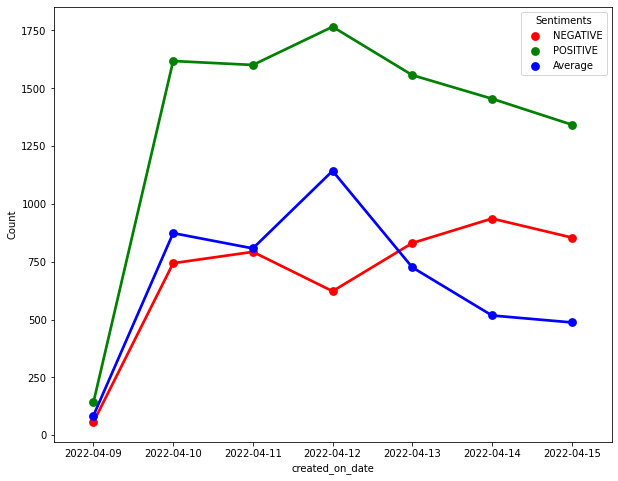

In [11]:
plt.figure(figsize = (10,8))
sns.pointplot(x="created_on_date", y='Count', hue='Sentiments', palette=['r', 'g','b'], data=dfm)
plt.show()

# Get Ethereum Price from Yahoo Finance

In [43]:
# Get Adjusted Close price for different stocks from Yahoo Finance 
def getQuotes(security, start_date, end_date, quote_type, interval):
   eth_ticker = yf.Ticker(security)
   quotes_df = eth_ticker.history(
    start=start_date,
    end=end_date,
    interval=interval
    )[quote_type].reset_index()
   mean_price = quotes_df['Close'].mean()
   return mean_price, quotes_df
''' 
  quotes_df = yf.download(securities, 
                      start=start_date, 
                      end=end_date, 
                      time_interval=interval)[quote_type]
''' 

# List of Stocks
STOCK_NAME = 'ETH-USD'
mean_price,daily_quote_ser = getQuotes(STOCK_NAME, '2022-04-10', '2022-04-16', 'Close', '5m')
daily_quote_df = pd.DataFrame(daily_quote_ser)
print('Mean price for Etherium:', mean_price)
daily_quote_df

Mean price for Etherium: 3087.0192341274687


,Datetime,Close
0,2022-04-10 00:00:00+00:00,3256.620605
1,2022-04-10 00:05:00+00:00,3256.188721
2,2022-04-10 00:10:00+00:00,3255.992188
3,2022-04-10 00:15:00+00:00,3252.576172
4,2022-04-10 00:20:00+00:00,3250.294434
...,...,...
1723,2022-04-15 23:35:00+00:00,3035.731201
1724,2022-04-15 23:40:00+00:00,3040.536377
1725,2022-04-15 23:45:00+00:00,3041.381348
1726,2022-04-15 23:50:00+00:00,3041.982666


Text(0, 0.5, 'Price ($)')

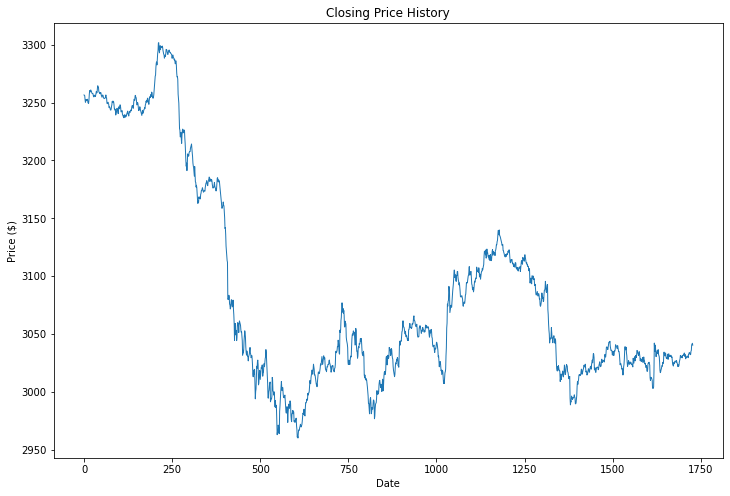

In [36]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(daily_quote_df['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Price ($)')

In [44]:
# create a single negative-positive sentiment value
graph_df=twitter_predicted_vis_df.copy()
graph_df['sentiment_score'] = graph_df['flair_sentiment_code']*20 + mean_price
graph_df

,created_at,text,flair_probability,flair_sentiment,flair_sentiment_code,created_on_date,sentiment_score
0,2022-04-15 21:51:30+00:00,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE,1,2022-04-15,3107.019234
1,2022-04-15 21:51:30+00:00,RT YachtClubNFT 💎ETH Giveaway💎 🎁Prizes 🏆40 ETH...,0.893260,POSITIVE,1,2022-04-15,3107.019234
2,2022-04-15 21:51:28+00:00,RT DancingDeerNFT 🎁NFT+ETH GIVEAWAY🎁 Prizes 🏆2...,0.974201,POSITIVE,1,2022-04-15,3107.019234
3,2022-04-15 21:51:28+00:00,RT Ceyhunakan60 AltcoinDailyio AltcoinDailyio ...,0.941798,NEGATIVE,-1,2022-04-15,3067.019234
4,2022-04-15 21:51:27+00:00,I just caught 110k just for free btc bitcoin b...,0.998054,NEGATIVE,-1,2022-04-15,3067.019234
...,...,...,...,...,...,...,...
14317,2022-04-09 22:49:40+00:00,RT ApesGenX The virus never stood chance The t...,0.999942,NEGATIVE,-1,2022-04-09,3067.019234
14318,2022-04-09 22:49:39+00:00,RT DarrenPromoter 🐺 Star Wolvez Generative 🐺 8...,0.997141,POSITIVE,1,2022-04-09,3107.019234
14319,2022-04-09 22:49:35+00:00,Floor price 01 eth different collection differ...,0.865415,NEGATIVE,-1,2022-04-09,3067.019234
14320,2022-04-09 22:49:33+00:00,RT Bitsubishi 🌍 Presenting Bitsubishi The Most...,0.998281,POSITIVE,1,2022-04-09,3107.019234


In [101]:
graph_df1=graph_df.drop(columns=['text','flair_probability','flair_sentiment','created_on_date','sentiment_score'])
graph_ser=graph_df1.resample('5min', on='created_at')['flair_sentiment_code'].sum()
graph_final_df=pd.DataFrame({'created_at':graph_ser.index, 'sentiment_score':graph_ser.values})
graph_final_df

,created_at,sentiment_score
0,2022-04-09 22:45:00+00:00,8
1,2022-04-09 22:50:00+00:00,35
2,2022-04-09 22:55:00+00:00,0
3,2022-04-09 23:00:00+00:00,0
4,2022-04-09 23:05:00+00:00,0
...,...,...
1713,2022-04-15 21:30:00+00:00,0
1714,2022-04-15 21:35:00+00:00,0
1715,2022-04-15 21:40:00+00:00,0
1716,2022-04-15 21:45:00+00:00,0


In [102]:
graph_final_df['sentiment_score'] = graph_final_df['sentiment_score']*20 + mean_price
graph_final_df

,created_at,sentiment_score
0,2022-04-09 22:45:00+00:00,3247.019234
1,2022-04-09 22:50:00+00:00,3787.019234
2,2022-04-09 22:55:00+00:00,3087.019234
3,2022-04-09 23:00:00+00:00,3087.019234
4,2022-04-09 23:05:00+00:00,3087.019234
...,...,...
1713,2022-04-15 21:30:00+00:00,3087.019234
1714,2022-04-15 21:35:00+00:00,3087.019234
1715,2022-04-15 21:40:00+00:00,3087.019234
1716,2022-04-15 21:45:00+00:00,3087.019234


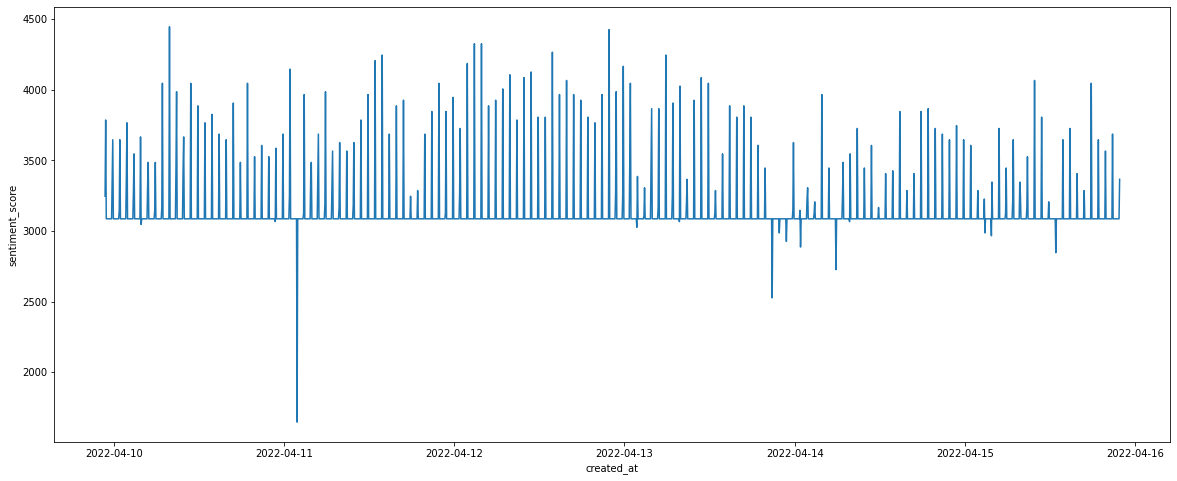

In [103]:
# plot the sentiment data
plt.figure(figsize=(20,8))
sns.lineplot(x=graph_final_df['created_at'], y=graph_final_df['sentiment_score'])

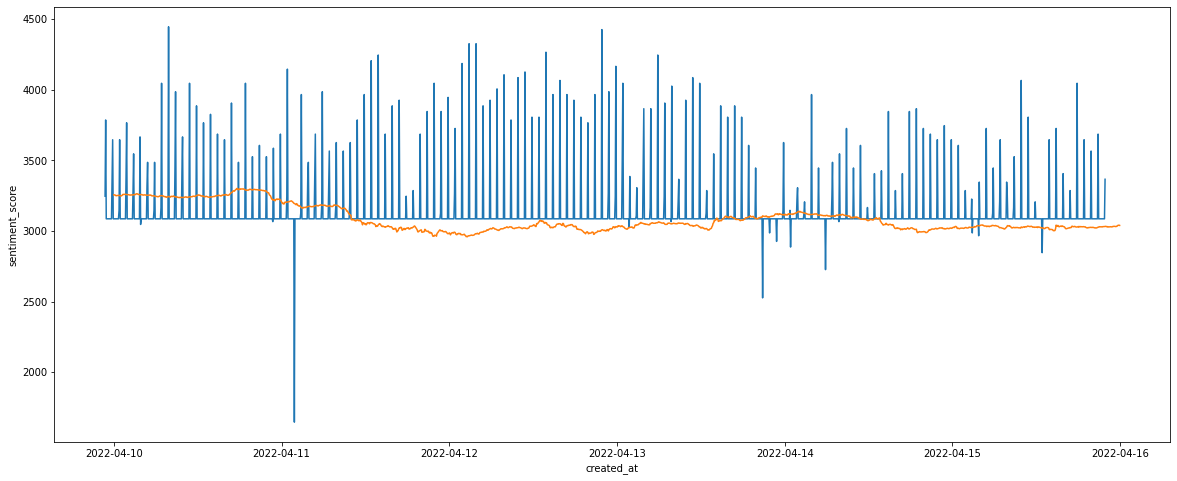

In [104]:
# import matplotlib as seaborn for plotting the graph
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,8))
# plot the sentiment data
sns.lineplot(x=graph_final_df['created_at'], y=graph_final_df['sentiment_score'])
# and the tesla stock price
sns.lineplot(x=daily_quote_df['Datetime'], y=daily_quote_df['Close'])

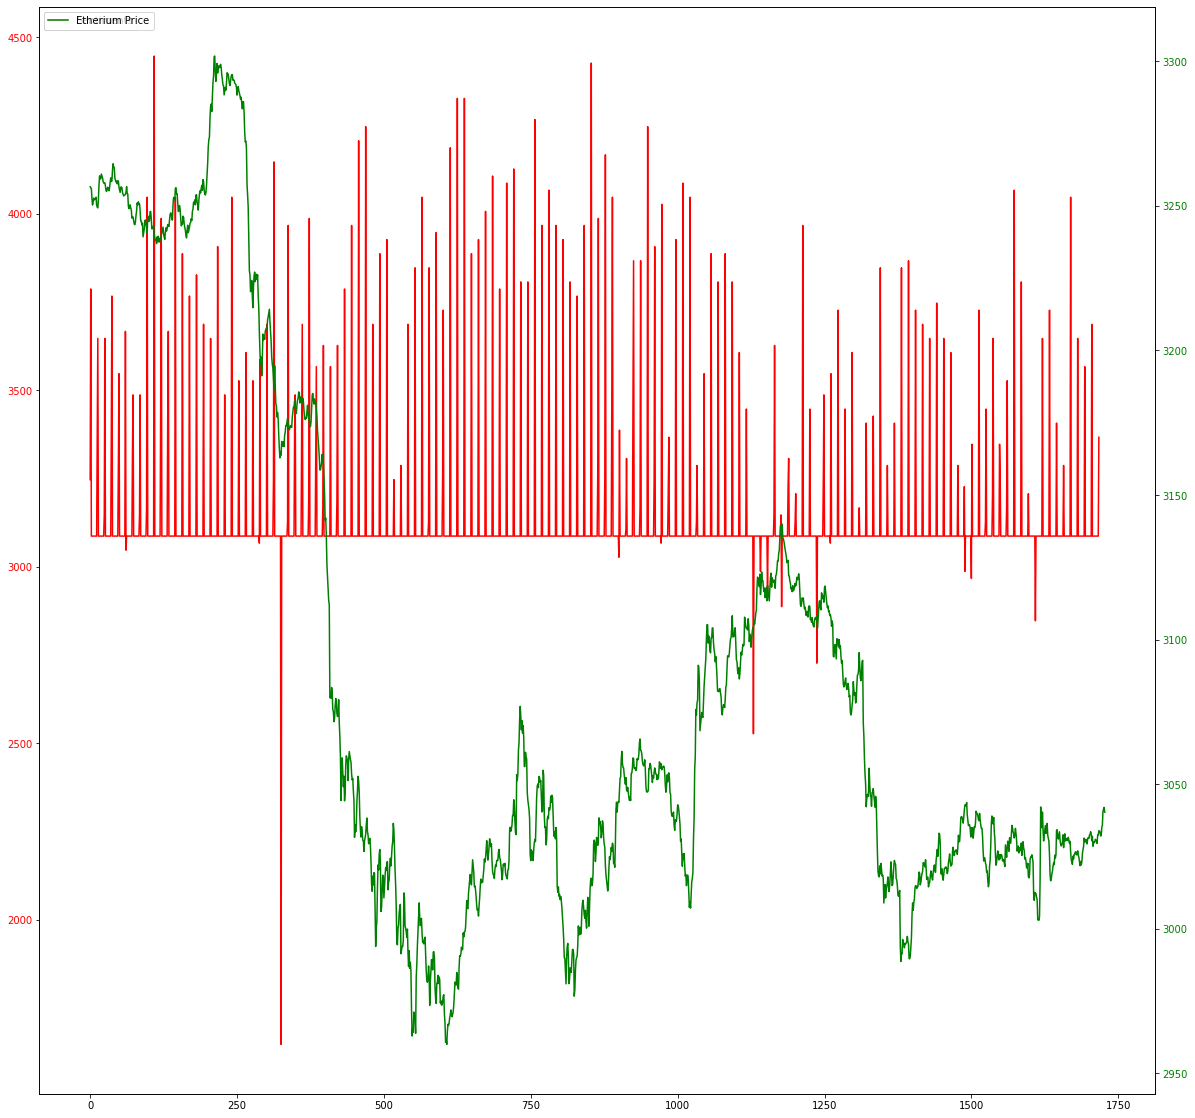

In [116]:
fig, ax = plt.subplots()
# Plot linear sequence, and set tick labels to the same color
ax.plot(graph_final_df['sentiment_score'], color='red', label = 'Sentiments')
ax.tick_params(axis='y', labelcolor='red')
ax.legend(loc = 'upper left')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(daily_quote_df['Close'], color='green', label = 'Etherium Price')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc = 'upper left')

plt.rcParams["figure.figsize"] = (20,20)
plt.show()